In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
#before this experiment, the 'romana_final' experiment needs to be run
#we'd like to predict the last column 'rezultatul final' which is a categorical value with 2 possible values: Respins or Reusit
#so this is a Classification problem
df = pd.read_csv('note.csv')
df = df.reset_index()


Y = df['rezultatul final']  

In [3]:
Y.head()

0    Respins
1    Respins
2    Respins
3    Respins
4    Respins
Name: rezultatul final, dtype: object

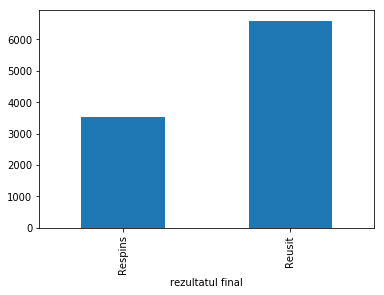

In [4]:
#we can see that the target value is not unbalanced fortunately
plt.clf()
df.groupby(Y).size().plot(kind='bar')
plt.show()

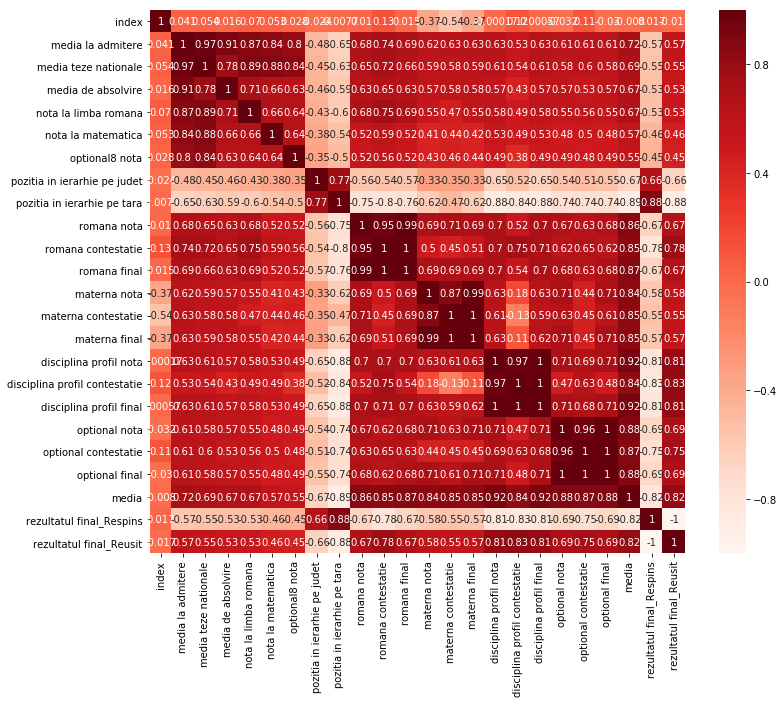

In [5]:
#see correlations between features
#Pearson Correlation
#must transform target label to numerical one
df2 = pd.get_dummies(df, columns=['rezultatul final'])
plt.figure(figsize=(12,10))
cor = df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
#OK, we can see that our target label is in really high correlation with several features
#this is because our target label is calculated based on these columns
#we will simply drop these columns
#in the end we'd like to predict this label only based on the grades of the 'Evalueare nationala' and other(only) categorical
#features from the Baccalaureate such as the type of the class, the name of the optional subject etc.
X = df[['nume','media teze nationale', 'nota la limba romana','judet8','scoala','media de absolvire','nota la matematica',
       'optional8 nota','limba materna8','promotie anterioara','specializare','limba moderna','disciplina profil','optional']]

In [7]:
#no empty columns, great
X.isna().sum()

nume                    0
media teze nationale    0
nota la limba romana    0
judet8                  0
scoala                  0
media de absolvire      0
nota la matematica      0
optional8 nota          0
limba materna8          0
promotie anterioara     0
specializare            0
limba moderna           0
disciplina profil       0
optional                0
dtype: int64

In [8]:
#as in the prediction of 'romama final' we'll encode the 'nume' column
#replace the name column with firstnames
def firstname(name):
    fullname_list = name.split(" ")
    return fullname_list[len(fullname_list)-1]

X['nume'] = X['nume'].apply(firstname)

In [9]:
X['nume']

0                         florin
1                         darius
2                           doru
3                         bogdan
4                       georgian
5                         vasile
6                          iozef
7                          ionut
8                         daniel
9                       cristian
10                        adrian
11                        daniel
12                         tudor
13                        marius
14                      cristian
15                        alicia
16                    constantin
17                        vasile
18                         ionut
19                         petru
20                        george
21                        florin
22                      cristian
23                       claudia
24                      anamaria
25                       andreea
26                        cornel
27                        teofil
28                         ionut
29                         maria
          

In [10]:
#but we have students with several firstnames, we encode them with pandas' built in one hot encoder
#so we store all the firstnames of a student
names = X['nume'].str.get_dummies(sep='-').add_prefix('nume_')
names.head()

nume_abel  nume_achim  nume_ada  nume_adalbert  nume_adam  nume_adel  \
0          0           0         0              0          0          0   
1          0           0         0              0          0          0   
2          0           0         0              0          0          0   
3          0           0         0              0          0          0   
4          0           0         0              0          0          0   

   nume_adela  nume_adelin  nume_adelina  nume_adeline  ...  nume_zina  \
0           0            0             0             0  ...          0   
1           0            0             0             0  ...          0   
2           0            0             0             0  ...          0   
3           0            0             0             0  ...          0   
4           0            0             0             0  ...          0   

   nume_zita  nume_zoltan  nume_zorand  nume_zsofia  nume_zsolt  nume_zsombor  \
0          0            0            0            0           0             0   
1          0            0            0            0           0             0   
2          0            0            0            0           0             0   
3          0            0            0            0           0             0   
4          0            0            0            0           0             0   

   nume_zsuzsa  nume_zsuzsana  nume_zsuzsanna  
0            0              0               0  
1            0              0               0  
2            0              0               0  
3            0              0               0  
4            0              0               0  

[5 rows x 1023 columns]

In [11]:
#merge new name columns with the old dataframe
X = pd.concat([X, names], axis = 1)

#drop the old name column
X = X.drop('nume', axis=1)
X.head()

media teze nationale  nota la limba romana judet8  \
0                  9.10                  8.17  BIHOR   
1                  8.63                  8.30  BIHOR   
2                  7.90                  7.62  BIHOR   
3                  8.21                  7.30  BIHOR   
4                  7.73                  6.40  BIHOR   

                                 scoala  media de absolvire  \
0            SC.CU CLS.I-VIII PIETROASA                9.54   
1  SC.CU CLS.I-VIII "N.POPOVICIU" BEIUS                9.62   
2             SC.CU CLS.I-VIII CALUGARI                9.52   
3              SC.CU CLS.I-VIII CARASAU                8.51   
4     LICEUL PEDAGOGIC "N.BOLCAS" BEIUS                8.89   

   nota la matematica  optional8 nota limba materna8 promotie anterioara  \
0                9.45            9.70              -                  Nu   
1                8.00            9.60              -                  Nu   
2                6.97            9.10              -                  Nu   
3                7.95            9.40              -                  Nu   
4                8.72            8.07              -                  Nu   

                                        specializare  ... nume_zina nume_zita  \
0  Tehnician in silvicultura si exploatari forest...  ...         0         0   
1  Tehnician in silvicultura si exploatari forest...  ...         0         0   
2  Tehnician in silvicultura si exploatari forest...  ...         0         0   
3  Tehnician in silvicultura si exploatari forest...  ...         0         0   
4  Tehnician in silvicultura si exploatari forest...  ...         0         0   

  nume_zoltan  nume_zorand  nume_zsofia  nume_zsolt  nume_zsombor  \
0           0            0            0           0             0   
1           0            0            0           0             0   
2           0            0            0           0             0   
3           0            0            0           0             0   
4           0            0            0           0             0   

   nume_zsuzsa  nume_zsuzsana  nume_zsuzsanna  
0            0              0               0  
1            0              0               0  
2            0              0               0  
3            0              0               0  
4            0              0               0  

[5 rows x 1036 columns]

In [12]:
#these features will be converted to numeric values

categorical_features = []
categorical_features_indices = []
for i,c in enumerate(X.columns):
        if X[c].dtype == 'object':
            categorical_features.append(c)
            categorical_features_indices.append(i)      
categorical_features

['judet8',
 'scoala',
 'limba materna8',
 'promotie anterioara',
 'specializare',
 'limba moderna',
 'disciplina profil',
 'optional']

In [13]:
#dummy variables
X_dummy = pd.get_dummies(X, columns=categorical_features)

In [14]:
X_dummy.head()

media teze nationale  nota la limba romana  media de absolvire  \
0                  9.10                  8.17                9.54   
1                  8.63                  8.30                9.62   
2                  7.90                  7.62                9.52   
3                  8.21                  7.30                8.51   
4                  7.73                  6.40                8.89   

   nota la matematica  optional8 nota  nume_abel  nume_achim  nume_ada  \
0                9.45            9.70          0           0         0   
1                8.00            9.60          0           0         0   
2                6.97            9.10          0           0         0   
3                7.95            9.40          0           0         0   
4                8.72            8.07          0           0         0   

   nume_adalbert  nume_adam  ...  optional_Filosofie  optional_Fizica  \
0              0          0  ...                   0                0   
1              0          0  ...                   0                0   
2              0          0  ...                   0                0   
3              0          0  ...                   0                0   
4              0          0  ...                   0                0   

   optional_Geografie  optional_Informatica T1 C/C++  \
0                   0                              0   
1                   0                              0   
2                   0                              0   
3                   0                              0   
4                   0                              0   

   optional_Informatica T1 Pascal  optional_Informatica T2 C/C++  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   optional_Informatica T2 Pascal  optional_Logica si argumentare  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   optional_Psihologie  optional_Sociologie  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    0                    0  

[5 rows x 3899 columns]

In [15]:
#let's predict
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, Y, test_size=0.20, random_state = 40) #same seed to compare results


model = RandomForestClassifier(n_jobs=-1, n_estimators=100)
model.fit(X_train, Y_train.ravel())
Y_pred = model.predict(X_test)
print accuracy_score(Y_pred, Y_test)

0.8324270884824518


In [16]:
#great, 83% accuracy, now let's see the confusion matrix and the recall and precision because
#in a classification problem they are really important
print confusion_matrix(Y_test, Y_pred)

print precision_score(Y_test, Y_pred, average='macro') 
print recall_score(Y_test, Y_pred, average='macro') 

[[ 535  171]
 [ 168 1149]]
0.8157393637656796
0.8151138629514671


In [17]:
#ok we can see, that we don;t have a lot of false positives and false negatives

In [18]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_dummy.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

feature_importances

importance
nota la limba romana                                  0.088425
media de absolvire                                    0.087383
media teze nationale                                  0.086470
optional8 nota                                        0.076526
nota la matematica                                    0.066197
disciplina profil_Matematica T2                       0.023924
disciplina profil_Istorie                             0.023638
optional_Biologie vegetala si animala T1              0.021727
specializare_Filologie                                0.017445
optional_Geografie                                    0.010273
specializare_Stiinte ale Naturii                      0.009661
limba materna8_-                                      0.007326
judet8_BIHOR                                          0.007111
limba materna8_Maghiara                               0.006543
specializare_Tehnician operator tehnica de calcul     0.005905
judet8_HARGHITA                                       0.005003
disciplina profil_Matematica T1                       0.004988
specializare_Matematica-Informatica                   0.004842
specializare_Stiinte Sociale                          0.004766
optional_Anatomie si fiziologie umana, genetica...    0.004708
specializare_Tehnician in turism                      0.004648
limba moderna_Engleza                                 0.004577
limba moderna_Franceza                                0.004375
specializare_Tehnician in instalatii electrice        0.004296
specializare_Tehnician ecolog si protectia cali...    0.004086
specializare_Tehnician in activitati economice        0.003744
judet8_SATU-MARE                                      0.003661
specializare_Tehnician mecatronist                    0.003502
judet8_SUCEAVA                                        0.003370
nume_maria                                            0.003040
...                                                        ...
scoala_SCOALA DE ARTE SI MESERII GHERMANESTI          0.000000
nume_steluta                                          0.000000
nume_ignac                                            0.000000
scoala_SCOALA CU CLS.I-VIII BASCOVENI                 0.000000
scoala_SCOALA CU CLS.I-VIII MOSTENI (MOSTENI)         0.000000
nume_iringo                                           0.000000
scoala_SCOALA GENERALA NR.1 TICLENI                   0.000000
scoala_SC.CU CLS.I-VIII TASAD                         0.000000
scoala_COLEGIUL NATIONAL "I MAIORESCU" GIURGIU        0.000000
scoala_SCOALA GENERALA NR.1 NEGOMIR                   0.000000
scoala_SCOALA CU CLS.I-VIII CIUPERCENI (COSMESTI)     0.000000
scoala_SCOALA CU CLASELE I-VIII "VASILE ALECSAN...    0.000000
scoala_SCOALA CU CLASELE I-VIII "UNIREA" PLOIESTI     0.000000
scoala_SCOALA CU CLASELE I-VIII "TRAIAN SAVULES...    0.000000
nume_sofica                                           0.000000
nume_iosefina                                         0.000000
scoala_SCOALA CU CLS.I-VIII SMARDIOASA                0.000000
nume_ilenuta                                          0.000000
scoala_SCOALA CU CLASELE I-VIII "PETRU RARES" H...    0.000000
scoala_SC.CU CLS.I-VIII URVIS                         0.000000
nume_ines                                             0.000000
nume_dragan                                           0.000000
scoala_SCOALA CU CLASELE I-VIII "PETRE DULFU" B...    0.000000
nume_dragomir                                         0.000000
scoala_SCOALA DE ARTE SI MESERII "I.R.ROSETTI" ...    0.000000
scoala_SCOALA CU CLASELE I-VIII "NICOLAE IORGA"...    0.000000
scoala_SC.I-VIII CHECHIS                              0.000000
scoala_SCOALA DE ARTE SI MESERII "IONEL TEODORE...    0.000000
scoala_SC.I-VIII CORNESTI                             0.000000
scoala_SCOALA CU CLASELE I-VIII NR 2 BRATILA          0.000000

[3899 rows x 1 columns]

Text(0.5,0,'Relative Importance')

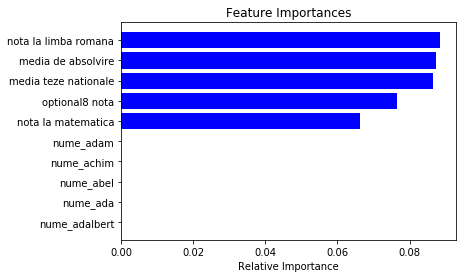

In [19]:
#top 10 feature importances seen on a plot

importances = model.feature_importances_[:10]
indices = np.argsort(importances)
features = X_dummy.columns

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [20]:
#these are our importances for every one hot encoding
#now let's try to do the same experiment

In [21]:
X_label = X.copy()

for i,c in enumerate(X.columns):
        if X[c].dtype == 'object':
            lbl = LabelEncoder()
            lbl.fit(list(X[c].values))
            X_label[c] = lbl.transform(list(X[c].values)) 
X_label.head()

media teze nationale  nota la limba romana  judet8  scoala  \
0                  9.10                  8.17       4     478   
1                  8.63                  8.30       4     391   
2                  7.90                  7.62       4     419   
3                  8.21                  7.30       4     421   
4                  7.73                  6.40       4     286   

   media de absolvire  nota la matematica  optional8 nota  limba materna8  \
0                9.54                9.45            9.70               0   
1                9.62                8.00            9.60               0   
2                9.52                6.97            9.10               0   
3                8.51                7.95            9.40               0   
4                8.89                8.72            8.07               0   

   promotie anterioara  specializare  ...  nume_zina  nume_zita  nume_zoltan  \
0                    1            43  ...          0          0            0   
1                    1            43  ...          0          0            0   
2                    1            43  ...          0          0            0   
3                    1            43  ...          0          0            0   
4                    1            43  ...          0          0            0   

   nume_zorand  nume_zsofia  nume_zsolt  nume_zsombor  nume_zsuzsa  \
0            0            0           0             0            0   
1            0            0           0             0            0   
2            0            0           0             0            0   
3            0            0           0             0            0   
4            0            0           0             0            0   

   nume_zsuzsana  nume_zsuzsanna  
0              0               0  
1              0               0  
2              0               0  
3              0               0  
4              0               0  

[5 rows x 1036 columns]

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_label, Y, test_size=0.20, random_state = 40)
model = RandomForestClassifier(n_jobs=-1, n_estimators=100)
model.fit(X_train, Y_train.ravel())
Y_pred = model.predict(X_test)
print accuracy_score(Y_pred, Y_test)

0.8398418190805734


In [42]:

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_label.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)


#drop 'nume' based columns because it cannot be label encoded beacuse of multiple values
no_names = [ind for ind in feature_importances.index if "nume" not in ind]
print no_names

['media teze nationale', 'media de absolvire', 'nota la matematica', 'nota la limba romana', 'specializare', 'optional8 nota', 'scoala', 'disciplina profil', 'judet8', 'optional', 'limba materna8', 'limba moderna', 'promotie anterioara']


In [43]:
feature_importances.loc[no_names]

importance
media teze nationale    0.128042
media de absolvire      0.111838
nota la matematica      0.089579
nota la limba romana    0.087775
specializare            0.085847
optional8 nota          0.080158
scoala                  0.054488
disciplina profil       0.045106
judet8                  0.042384
optional                0.041298
limba materna8          0.011786
limba moderna           0.010688
promotie anterioara     0.002309

Text(0.5,0,'Relative Importance')

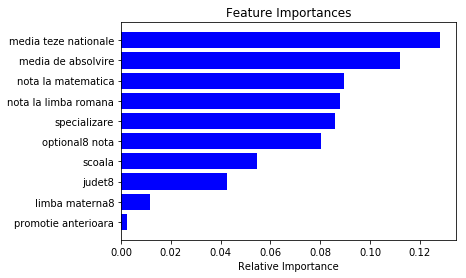

In [45]:
importances = model.feature_importances_[:10]
indices = np.argsort(importances)
features = X_label.columns

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')